Best SVM Accuracy: 0.7307692307692307
Best SVM Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.69      0.69        13
           1       0.73      0.73      0.73        11
           2       0.71      0.77      0.74        13
           3       0.79      0.73      0.76        15

    accuracy                           0.73        52
   macro avg       0.73      0.73      0.73        52
weighted avg       0.73      0.73      0.73        52

Best SVM Confusion Matrix:
 [[ 9  1  1  2]
 [ 1  8  2  0]
 [ 0  2 10  1]
 [ 3  0  1 11]]


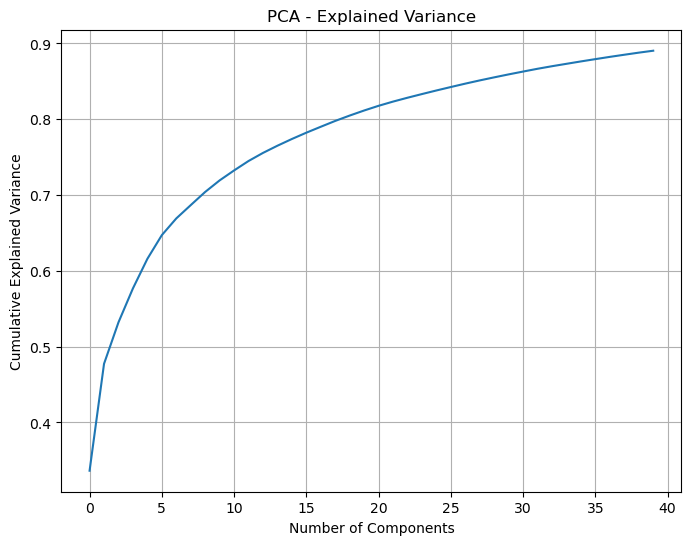

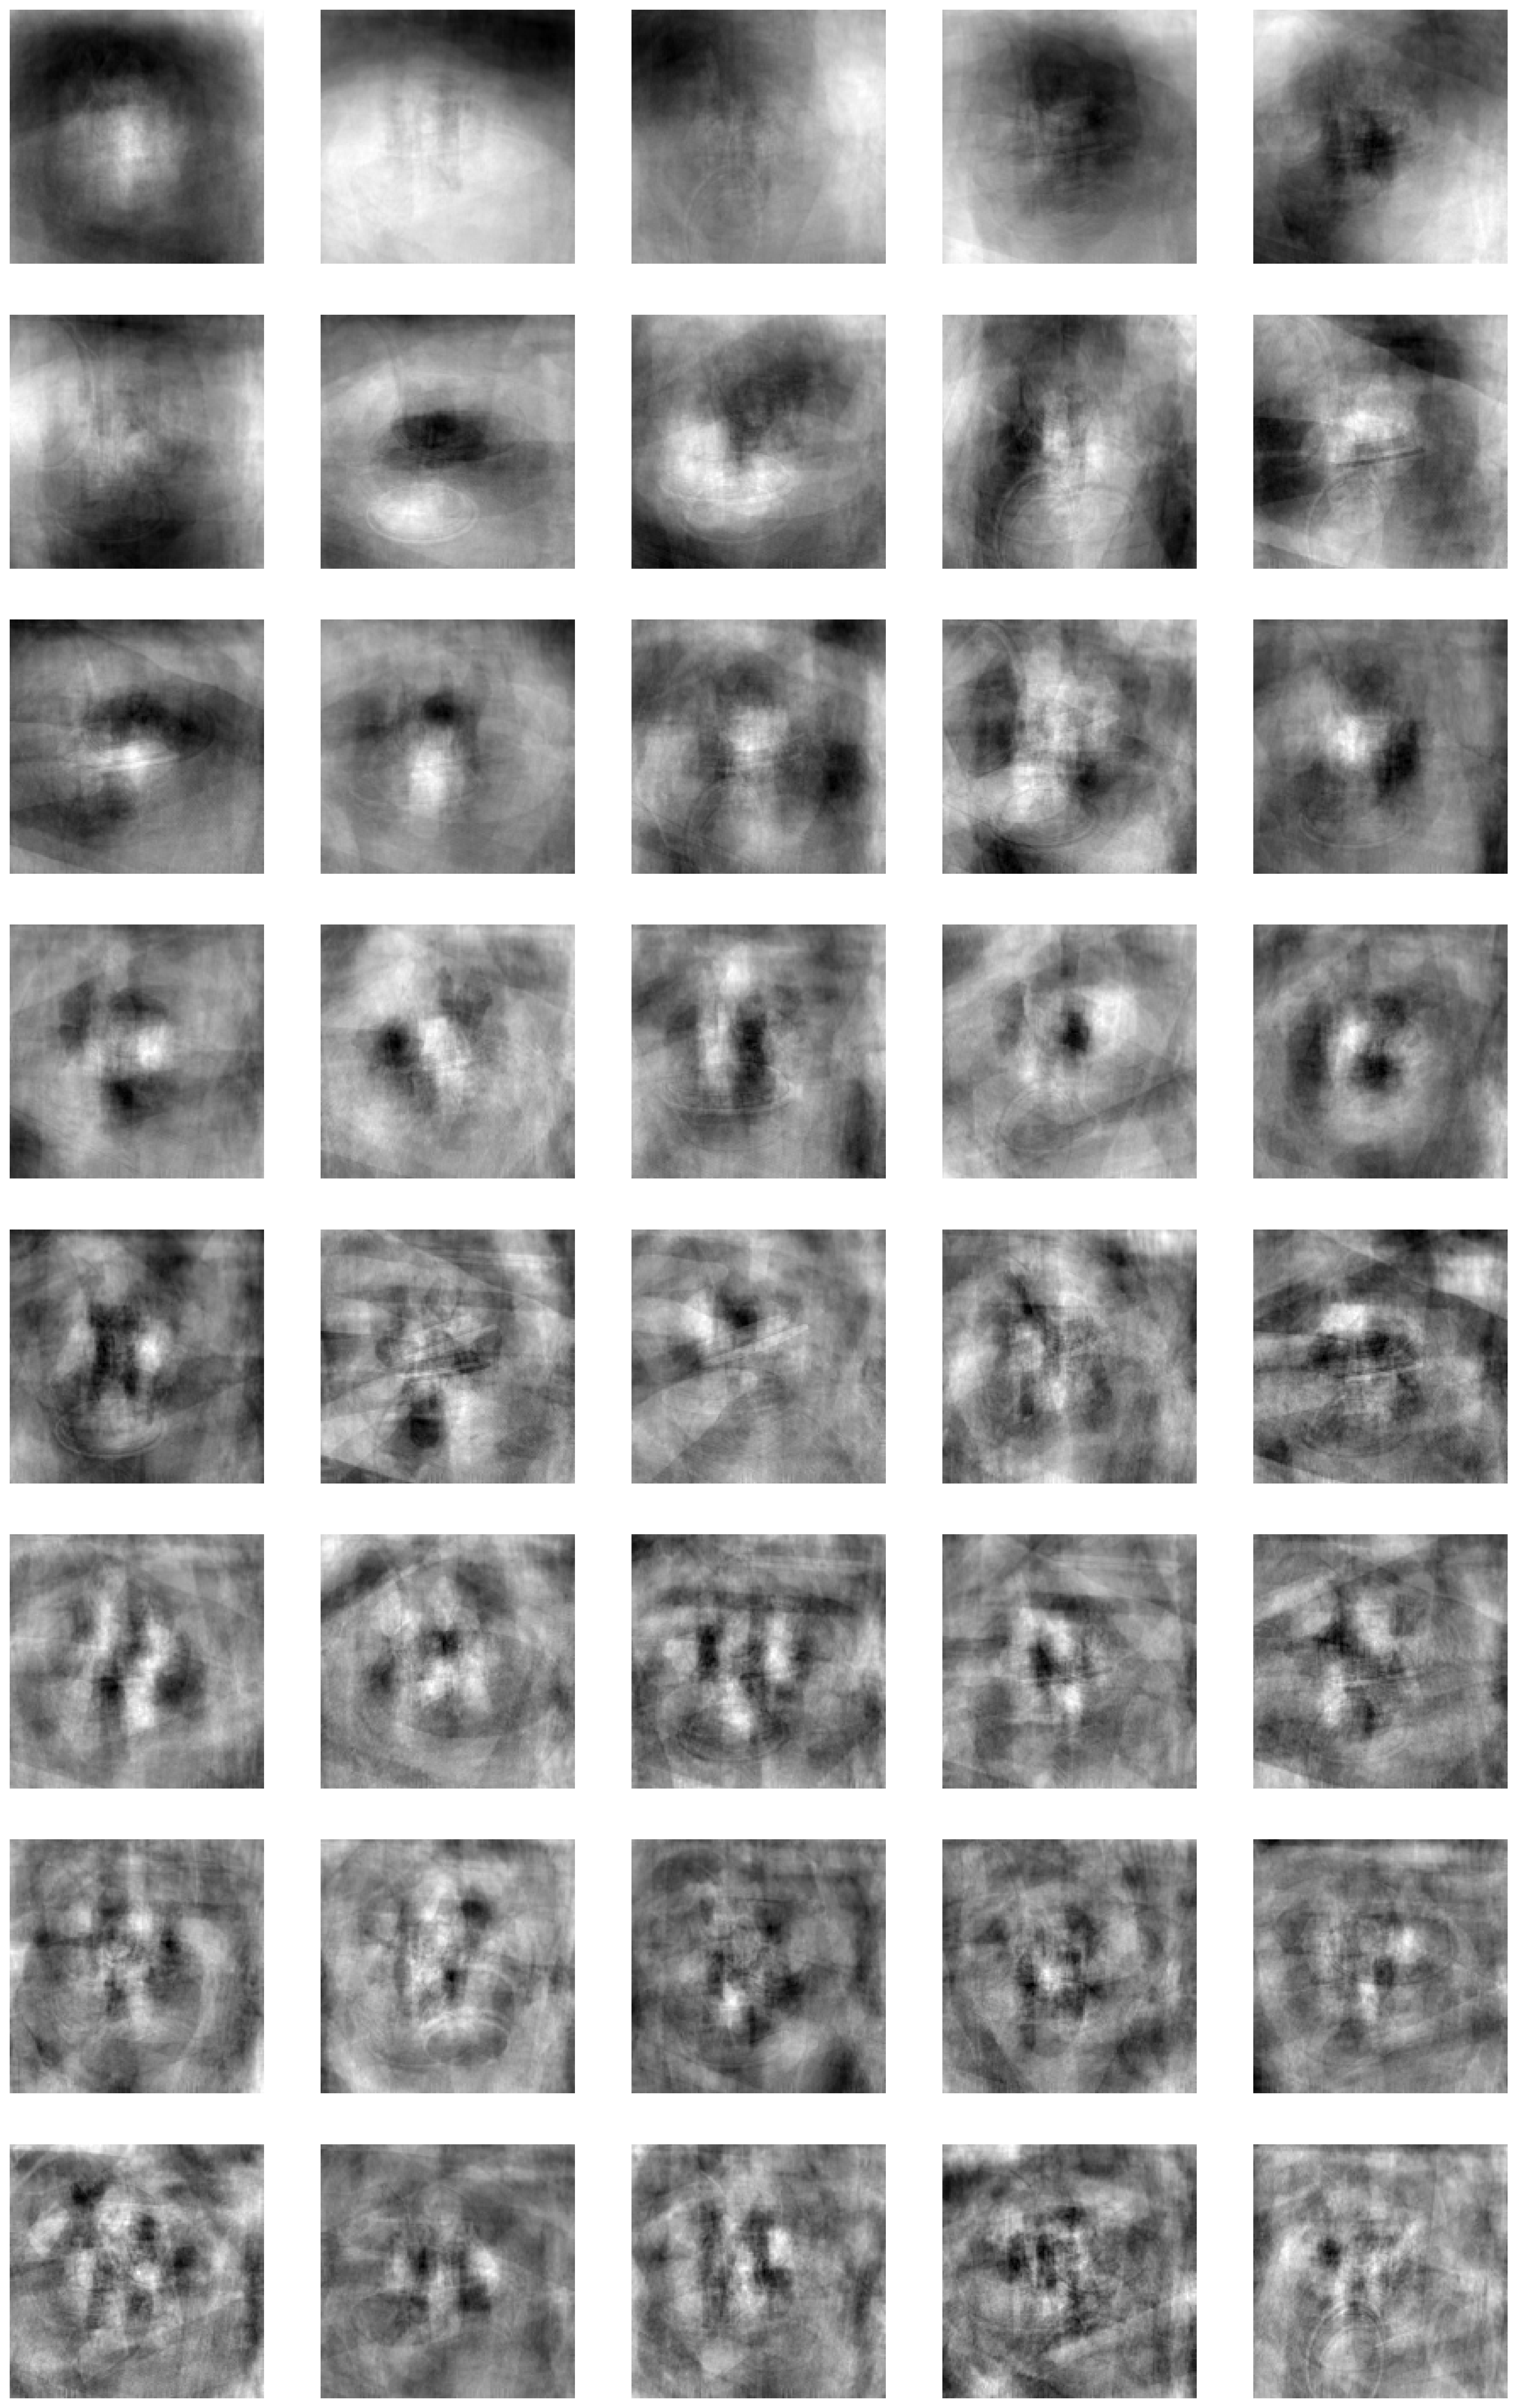

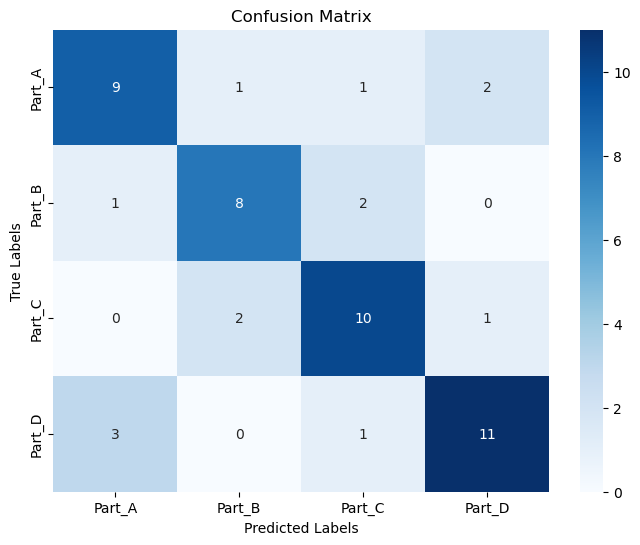

Number of parts in Part_A_65.jpg (Folder: Part_A): 1
Number of parts in Part_A_66.jpg (Folder: Part_A): 1
Number of parts in Part_A_67.jpg (Folder: Part_A): 2
Number of parts in Part_A_68.jpg (Folder: Part_A): 2
Number of parts in Part_A_69.jpg (Folder: Part_A): 1
Number of parts in Part_A_70.jpg (Folder: Part_A): 1
Number of parts in Part_A_71.jpg (Folder: Part_A): 1
Number of parts in Part_A_72.jpg (Folder: Part_A): 1
Number of parts in Part_A_73.jpg (Folder: Part_A): 2
Number of parts in Part_A_74.jpg (Folder: Part_A): 2
Number of parts in Part_A_75.jpg (Folder: Part_A): 1
Number of parts in Part_A_76.jpg (Folder: Part_A): 1
Number of parts in Part_A_77.jpg (Folder: Part_A): 1
Number of parts in Part_A_78.jpg (Folder: Part_A): 3
Number of parts in Part_A_79.jpg (Folder: Part_A): 1
Number of parts in Part_A_80.jpg (Folder: Part_A): 1
Number of parts in Part_B_65.jpg (Folder: Part_B): 2
Number of parts in Part_B_66.jpg (Folder: Part_B): 2
Number of parts in Part_B_67.jpg (Folder: Part

In [5]:
import os
import glob
import cv2
import numpy as np
from PIL import Image
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import math
import h5py

# Preprocessing function
def preprocess_images(folders, folder_path, image_size):
    image_names_list = []
    for folder in folders:
        for f in glob.glob(os.path.join(folder_path, folder, '*.jpg')):
            image_names_list.append(f)

    for image in image_names_list:
        pre_image = Image.open(image).convert('L')
        new_image = pre_image.resize(image_size)
        new_image.save(image)

# Load data function
def load_data(folders, folder_path, image_size):
    data = []
    for folder in folders:
        path = os.path.join(folder_path, folder)
        class_num = folders.index(folder)
        for image in os.listdir(path):
            image_array = cv2.imread(os.path.join(path, image), cv2.IMREAD_GRAYSCALE)
            new_array = cv2.resize(image_array, image_size)
            data.append([new_array, class_num])
    return data

# Extract features and labels function
def extract_features_labels(data):
    X = []
    Y = []
    for features, label in data:
        X.append(features)
        Y.append(label)

    X = np.array(X)
    Y = np.array(Y)
    X = X.reshape(X.shape[0], -1)
    X = X / 255.0
    return X, Y

# Split train and test data function
def split_train_test_data(X, Y, test_size):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
    return X_train, X_test, Y_train, Y_test

# Train the SVM model function
def train_svm(X_train, Y_train):
    param_grid = {
        'C': [1, 10, 100, 1000],  # Penalty parameter C
        'gamma': [0.001, 0.01, 0.1, 1],  # Kernel coefficient for 'rbf'
        'kernel': ['rbf', 'sigmoid', 'linear']  # Kernel options
    }
    grid_search = GridSearchCV(svm.SVC(class_weight='balanced'), param_grid, cv=5)
    grid_search.fit(X_train, Y_train)
    best_svm_classifier = grid_search.best_estimator_
    best_svm_classifier.fit(X_train, Y_train)
    return best_svm_classifier

# Evaluate the model function
def evaluate_model(classifier, X_test, Y_test):
    Y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(Y_test, Y_pred)
    classification_report_output = classification_report(Y_test, Y_pred)
    confusion_matrix_output = confusion_matrix(Y_test, Y_pred)
    return accuracy, classification_report_output, confusion_matrix_output

# Visualization functions
def plot_pca(pca, X_train):
    plt.figure(figsize=(8, 6))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA - Explained Variance')
    plt.grid(True)
    plt.show()

def show_eigenfaces(pca, image_size):
    eigenfaces = pca.components_.reshape(-1, image_size[0], image_size[1])
    num_components = len(eigenfaces)
    eigenfaces = eigenfaces.reshape((num_components, image_size[0], image_size[1]))
    image_grid(eigenfaces, image_size[0], image_size[1], cols=5)

def image_grid(D, H, W, cols=10, scale=1):
    n = np.shape(D)[0]
    rows = int(math.ceil((n + 0.0) / cols))
    fig = plt.figure(1, figsize=[scale * 20.0 / H * W, scale * 20.0 / cols * rows], dpi=300)
    for i in range(n):
        plt.subplot(rows, cols, i + 1)
        fig = plt.imshow(np.reshape(D[i, :], [H, W]), cmap=plt.get_cmap("gray"))
        plt.axis('off')

def show_images(data, folders):
    num_classes = len(folders)
    plt.figure(figsize=(10, 10))
    for i in range(num_classes):
        class_data = [x[0] for x in data if x[1] == i]
        class_name = folders[i]
        for j in range(5):
            plt.subplot(num_classes, 5, i * 5 + j + 1)
            plt.imshow(class_data[j], cmap='gray')
            plt.title(class_name)
            plt.axis('off')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(confusion_matrix_output, classes):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix_output, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


# Function to count parts in an image
def count_parts(image_path, threshold=128, min_area=500):
    # Load the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Apply a binary threshold to the image
    _, binary_image = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY_INV)
    
    # Find contours in the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Filter contours by minimum area
    parts_count = 0
    for contour in contours:
        if cv2.contourArea(contour) > min_area:
            parts_count += 1
    
    return parts_count



# Main execution logic
image_size = (150, 150)
test_folders = ['Part_A', 'Part_B', 'Part_C', 'Part_D']
train_folders = ['Part_A', 'Part_B', 'Part_C', 'Part_D']

# Preprocessing images
preprocess_images(test_folders, 'C:/Users/youse/Downloads/TPR project/TPR project/Test', image_size)
preprocess_images(train_folders, 'C:/Users/youse/Downloads/TPR project/TPR project/Train', image_size)

# Loading and feature extraction
train_data = load_data(train_folders, 'C:/Users/youse/Downloads/TPR project/TPR project/Train', image_size)
test_data = load_data(test_folders, 'C:/Users/youse/Downloads/TPR project/TPR project/Test', image_size)
X_train, Y_train = extract_features_labels(train_data)
X_test, Y_test = extract_features_labels(test_data)

# Ensuring correct split and model training
X_train, X_test, Y_train, Y_test = split_train_test_data(X_train, Y_train, test_size=0.2)
pca = PCA(n_components=40)
pca.fit(X_train)
X_pca_train = pca.transform(X_train)
X_pca_test = pca.transform(X_test)
best_svm_classifier = train_svm(X_pca_train, Y_train)

# Evaluation and visualization
accuracy_best, classification_report_best, confusion_matrix_best = evaluate_model(best_svm_classifier, X_pca_test, Y_test)
print("Best SVM Accuracy:", accuracy_best)
print("Best SVM Classification Report:\n", classification_report_best)
print("Best SVM Confusion Matrix:\n", confusion_matrix_best)

# Additional visualizations
plot_pca(pca, X_train)
show_eigenfaces(pca, image_size)
plot_confusion_matrix(confusion_matrix_best, train_folders)

# Counting parts in test images
for folder in test_folders:
    folder_path = os.path.join('C:/Users/youse/Downloads/TPR project/TPR project/Test', folder)
    for image_file in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_file)
        parts_count = count_parts(image_path)
        print(f'Number of parts in {image_file} (Folder: {folder}): {parts_count}')
